In [2]:
import jax.numpy as jnp
from jax import jit,grad,hessian,jacfwd
from jax.config import config
config.update("jax_enable_x64", True)
import numpy as np
import matplotlib.pyplot as plt

import jax

key = jax.random.PRNGKey(420)
from scipy.interpolate import CloughTocher2DInterpolator

def resample(X,y,m_interp=40):
    interp = CloughTocher2DInterpolator(X, y,fill_value=0)
    xgrid,ygrid = np.linspace(0,1,m_interp),np.linspace(0,1,m_interp)
    meshX,meshY=np.meshgrid(xgrid,ygrid)
    return xgrid,ygrid,interp(meshX,meshY)
plt.style.use('ggplot')

In [77]:
def get_gaussianRBF(gamma):
    def f(x,y):
        return jnp.exp(-jnp.sum((x-y)**2)/gamma)
    return f

def minus_div(f,arg_num=0):
    jac=jacfwd(f,argnums=arg_num)
    def divergence(x,y):
        return -1*jnp.trace(jac(x,y))
    return divergence

def k_laplacian(f,arg_num=0):
    return minus_div(grad(f,argnums=arg_num),arg_num=arg_num)

def laplacian(f,arg_num=0):
    hess= hessian(f,argnums=arg_num)
    def lap(x):
        return -1*jnp.trace(hess(x))
    return lap

k= get_gaussianRBF(0.1)
k_lapx = k_laplacian(k,arg_num=0)
k_laplap = k_laplacian(k_lapx,arg_num=1)


vec_k = jax.vmap(jax.vmap(k, in_axes=(0, None)), in_axes=(None, 0))
vec_k_lapx = jax.vmap(jax.vmap(k_lapx, in_axes=(0, None)), in_axes=(None, 0))
vec_k_laplap = jax.vmap(jax.vmap(k_laplap, in_axes=(0, None)), in_axes=(None, 0))

def true_solution_single(x):
    boundary_term = x[0]*(1-x[0])*x[1]*(1-x[1])
    interior = jnp.cos(5*jnp.pi*((0.5-x[0])**2 + (0.3*x[1])**2))
    return 4 * boundary_term * interior

def true_solution_single(x):
    return jnp.sin(3*jnp.pi*x[0])*jnp.sin(2*jnp.pi*x[1])


point_source= get_gaussianRBF(0.01)

def rhs_func_single(x):
    return point_source(x,jnp.array([0.4,0.4]))/0.01

rhs_func = jit(jax.vmap(rhs_func_single))

In [78]:
m_interp=50
xgrid,ygrid = np.linspace(0,1,m_interp),np.linspace(0,1,m_interp)
meshX,meshY=np.meshgrid(xgrid,ygrid)

interpolation_points = jnp.vstack([meshX.flatten(),meshY.flatten()]).T

interp_rhs=(rhs_func(interpolation_points)).reshape(m_interp,m_interp)

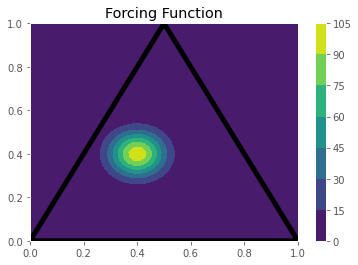

In [79]:
plt.title("Forcing Function")
plt.contourf(meshX,meshY,interp_rhs)
plt.plot([0,0.5,1,0],[0,1,0,0],c='black',lw=5)
plt.colorbar()
plt.show()

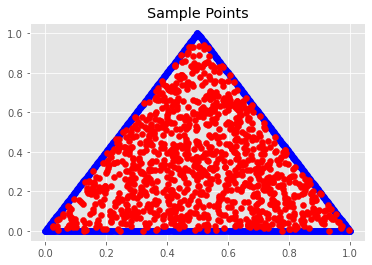

In [80]:
num_interior=2000

num_per_boundary=300
num_boundary=3*num_per_boundary



polygon_points=jnp.array([
    [0,0],
    [0.5,1],
    [1,0],
])

original_samples=jax.random.uniform(key,shape=(num_interior*10,2),minval=0,maxval=1)

first_satisfied=original_samples[:,1]<=2*original_samples[:,0]
second_satisfied=original_samples[:,1]<=2-2*original_samples[:,0]

interior_points=original_samples[first_satisfied*second_satisfied][:num_interior-num_boundary]

zero_one_points=jnp.linspace(0,1,num_per_boundary).reshape(-1,1)
boundary_points=jnp.vstack(
    [
        zero_one_points*polygon_points[0]+(1-zero_one_points)*polygon_points[1],
        zero_one_points*polygon_points[1]+(1-zero_one_points)*polygon_points[2],
        zero_one_points*polygon_points[2]+(1-zero_one_points)*polygon_points[0],
    ]
)

extra_sample_param=0.9
#extra_interior=(1-extra_sample_param)*jnp.array([0.5,0.4])+extra_sample_param*boundary_points
#interior_points=jnp.vstack([interior_points,extra_interior])
all_points = jnp.vstack([interior_points,boundary_points])

plt.title("Sample Points")
plt.scatter(boundary_points[:,0],boundary_points[:,1],c='blue')
plt.scatter(interior_points[:,0],interior_points[:,1],c='red')
plt.show()

In [81]:
K1 = vec_k_laplap(interior_points,interior_points)
K2 = vec_k_lapx(boundary_points,interior_points)
K3 = K2.T
K4 = vec_k(boundary_points,boundary_points)

K_full = jnp.block(
    [
        [K1,K2],
        [K3,K4]
    ]
)

interior_rhs = rhs_func(interior_points)
boundary_rhs = jnp.zeros(num_boundary)
rhs_total = jnp.hstack([interior_rhs,boundary_rhs])

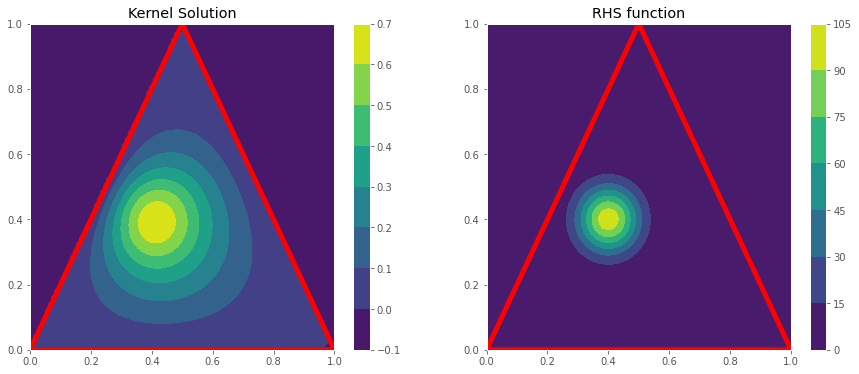

max norm residual and refined residual
0.7300245874155067


In [83]:
nugget=1e-10
Kmat=K_full+nugget*jnp.diag(jnp.diag(K_full))
coef_sol=jax.scipy.linalg.solve(Kmat,rhs_total,assume_a='pos')
residual = rhs_total - K_full@coef_sol
coef_sol_refined=coef_sol+jax.scipy.linalg.solve(Kmat,residual,assume_a='pos')

residual_refined = rhs_total - K_full@coef_sol_refined

eval_K=vec_k(interior_points,all_points).T
sol_vals = eval_K@coef_sol


num_grid_points=100
xgrid=jnp.linspace(0,1,num_grid_points)
ygrid=jnp.linspace(0,1,num_grid_points)

XX,YY=jnp.meshgrid(xgrid,ygrid)

interpolation_points = jnp.vstack([XX.flatten(),YY.flatten()]).T

first_satisfied=interpolation_points[:,1]<=2*interpolation_points[:,0]
second_satisfied=interpolation_points[:,1]<=2-2*interpolation_points[:,0]
is_outside=~(first_satisfied*second_satisfied)


interp_k = jnp.block(
    [
        [vec_k_lapx(interior_points,interpolation_points),vec_k(boundary_points,interpolation_points)]
    ]
)

interp_solution=(interp_k@coef_sol)
interp_solution=interp_solution.at[is_outside].set(0.)
interp_solution=interp_solution.reshape(num_grid_points,num_grid_points)


interp_rhs = rhs_func(interpolation_points).reshape(num_grid_points,num_grid_points)



fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,6))
plot1=ax1.contourf(xgrid,ygrid,interp_solution)
ax1.plot([0,0.5,1,0],[0,1,0,0],c='red',lw=5)

ax1.set_title("Kernel Solution")
plt.colorbar(plot1,ax=ax1)
plot2=ax2.contourf(xgrid,ygrid,interp_rhs)
plt.colorbar(plot2,ax=ax2)
ax2.plot([0,0.5,1,0],[0,1,0,0],c='red',lw=5)

ax2.set_title("RHS function")
plt.savefig("triangle_poisson_point.png")
plt.show()

print("max norm residual and refined residual")
print(jnp.max(jnp.abs(residual)))


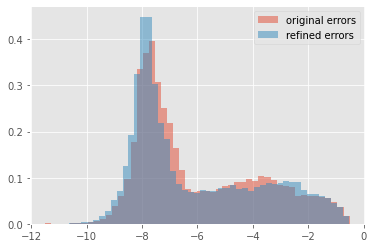

In [68]:
plt.hist(jnp.log10(jnp.abs(error.flatten()+1e-10)),50,alpha=0.5,density=True,label='original errors')
plt.hist(jnp.log10(jnp.abs(error_refined.flatten()+1e-10)),50,alpha=0.5,density=True,label='refined errors')
plt.legend()
plt.show()